Analysis of customer behaviours

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

%matplotlib inline
sns.set_style('ticks')

import warnings
warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/CRM/'
%ls

/content/drive/MyDrive/CRM
 01_data_prep.pkl                       interest_corr_overall.png
 consumption_freq.png                   interest_freq.png
'Customer Behaviors (Responses).xlsx'   K2D-Regular.ttf
'Customer Survey.xlsx'                  Retail_Data_Response.csv
 demographic.png                        Retail_Data_Transactions.csv
 interest_corr_female.png              'Supermarket Data.csv'


In [4]:
mpl.font_manager.fontManager.addfont('/content/drive/MyDrive/CRM/K2D-Regular.ttf')
mpl.rc('font', family='K2D', size=12, weight=200)

In [5]:
filename = 'Customer Behaviors (Responses).xlsx'
df_tmp = pd.read_excel(filename, dtype={'คุณเกิดวันที่เท่าไหร่' : str})
df_tmp.head()

,Timestamp,คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารญี่ปุ่น],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารจึน],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารไทย],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารอีสาน],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [อาหารสุขภาพ],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [บุฟเฟต์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ชาบูชาบู],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ปิ้งย่าง],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [เหล้าเบียร์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [เสื้อผ้าแฟชั่น],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [แต่งหน้า],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [skincare บำรุงผิว],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การออกกำลังกาย],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การเล่นเกมส์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การท่องเที่ยว],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การอ่านหนังสือ],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การอ่านบทความ Online],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [การเรียน e-learning],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดู Series],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดูหนัง],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดู Youtube],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [ดู Netflix],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content ด้านบันเทิง],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่่ยวกับเกมส์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการ review ร้านอาหาร],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการท่องเที่ยว],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการแต่งบ้าน],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการโทรทัศน์],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับละคร],คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด [Content เกี่ยวกับการเมือง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารญี่ปุ่น],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารจึน],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารไทย],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารอีสาน],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [อาหารสุขภาพ],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [บุฟเฟต์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ชาบูชาบู],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ปิ้งย่าง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [เหล้าเบียร์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [เสื้อผ้าแฟชั่น],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [แต่งหน้า],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [skincare บำรุงผิว],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การออกกำลังกาย],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การเล่นเกมส์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การท่องเที่ยว],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การอ่านหนังสือ],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การอ่านบทความ Online],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [การเรียน e-learning],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดู Series],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดูหนัง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดู Youtube],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [ดู Netflix],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content ด้านบันเทิง],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่่ยวกับเกมส์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการ review ร้านอาหาร],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการท่องเที่ยว],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการแต่งบ้าน],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการโทรทัศน์],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับละคร],คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน [Content เกี่ยวกับการเมือง],นอกเหนือจากรายการดังกล่าวแล้ว คุณมีความสนใจในเรื่องใดอีกบ้าง,คุณเกิดวันที่เท่าไหร่,เพศ
0,2021-01-09 10:07:27.365,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมากที่สุด,เดือนละ 2-3 ครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 คร

In [6]:
df_tmp = df_tmp[df_tmp.columns[1:]]

In [7]:
from datetime import datetime

df = df_tmp.copy()

# rename columns
int_cols = [ c.replace('คุณมีความสนใจในสิ่งเหล่านี้มากน้อยเพียงใด','Interest') for c in df.columns[:30] ]
con_cols = [ c.replace('คุณบริโภคสิ่งเหล่านี้บ่อยขนาดไหน','Consumption') for c in df.columns[30:60] ]
df.columns = int_cols + con_cols + ['interests', 'dob', 'gender']

# make answers categorical
intr_cattype = pd.CategoricalDtype(categories=['ไม่สนใจอย่างมากที่สุด', 'ไม่สนใจอย่างมาก', 'ไม่สนใจ', 
                                              'เฉยๆ', 'สนใจ', 'สนใจอย่างมาก', 'สนใจอย่างมากที่สุด'], ordered=True)
cons_cattype = pd.CategoricalDtype(categories=['แทบไม่ได้บริโภคเลย', 'หลายเดือนครั้ง', 'เดือนละครั้ง', 
                                               'เดือนละ 2-3 ครั้ง', 'อาทิตย์ละครั้ง', 'แทบทุกวัน'], ordered=True)

for col in df.columns[:30]:
    df[col] = df[col].astype(intr_cattype)

for col in df.columns[30:60]:
    df[col] = df[col].astype(cons_cattype)

# gender
df['gender'] = df['gender'].map({'หญิง':'F', 'ชาย':'M', 'ไม่ต้องการระบุ': np.nan})

# process dates
df['year'] = df['dob'].apply(lambda x: int(x.split()[0].split('-')[0]))
df['year'] = df['year'].apply(lambda x: x if x < 2500 else x - 543)
df['month'] = df['dob'].apply(lambda x: int(x.split()[0].split('-')[1]))
df['day'] = df['dob'].apply(lambda x: int(x.split()[0].split('-')[2]))

df['dob'] = pd.to_datetime(df[['year','month','day']])
df['age'] = df['year'].apply(lambda x: datetime.now().year - x if x < 2010 else np.nan)
df['age_group'] = pd.cut(df['age'], bins=[0,28,32,36,99], right=False, labels=['Below 28','28 - 31', '32 - 35','36+'])

df.drop(['year','month','day'], axis=1, inplace=True)

In [8]:
df.head()

,Interest [อาหารญี่ปุ่น],Interest [อาหารจึน],Interest [อาหารไทย],Interest [อาหารอีสาน],Interest [อาหารสุขภาพ],Interest [บุฟเฟต์],Interest [ชาบูชาบู],Interest [ปิ้งย่าง],Interest [เหล้าเบียร์],Interest [เสื้อผ้าแฟชั่น],Interest [แต่งหน้า],Interest [skincare บำรุงผิว],Interest [การออกกำลังกาย],Interest [การเล่นเกมส์],Interest [การท่องเที่ยว],Interest [การอ่านหนังสือ],Interest [การอ่านบทความ Online],Interest [การเรียน e-learning],Interest [ดู Series],Interest [ดูหนัง],Interest [ดู Youtube],Interest [ดู Netflix],Interest [Content ด้านบันเทิง],Interest [Content เกี่่ยวกับเกมส์],Interest [Content เกี่ยวกับการ review ร้านอาหาร],Interest [Content เกี่ยวกับการท่องเที่ยว],Interest [Content เกี่ยวกับการแต่งบ้าน],Interest [Content เกี่ยวกับการโทรทัศน์],Interest [Content เกี่ยวกับละคร],Interest [Content เกี่ยวกับการเมือง],Consumption [อาหารญี่ปุ่น],Consumption [อาหารจึน],Consumption [อาหารไทย],Consumption [อาหารอีสาน],Consumption [อาหารสุขภาพ],Consumption [บุฟเฟต์],Consumption [ชาบูชาบู],Consumption [ปิ้งย่าง],Consumption [เหล้าเบียร์],Consumption [เสื้อผ้าแฟชั่น],Consumption [แต่งหน้า],Consumption [skincare บำรุงผิว],Consumption [การออกกำลังกาย],Consumption [การเล่นเกมส์],Consumption [การท่องเที่ยว],Consumption [การอ่านหนังสือ],Consumption [การอ่านบทความ Online],Consumption [การเรียน e-learning],Consumption [ดู Series],Consumption [ดูหนัง],Consumption [ดู Youtube],Consumption [ดู Netflix],Consumption [Content ด้านบันเทิง],Consumption [Content เกี่่ยวกับเกมส์],Consumption [Content เกี่ยวกับการ review ร้านอาหาร],Consumption [Content เกี่ยวกับการท่องเที่ยว],Consumption [Content เกี่ยวกับการแต่งบ้าน],Consumption [Content เกี่ยวกับการโทรทัศน์],Consumption [Content เกี่ยวกับละคร],Consumption [Content เกี่ยวกับการเมือง],interests,dob,gender,age,age_group
0,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมากที่สุด,เดือนละ 2-3 ครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,"กีฬา UFC, Soccer",1988-09-19,M,33.0,32 - 35
1,สนใจอย่างมาก,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,กีฬา สัตว์เลี้ยง เทคโนโลยี,1993-08-10,F,28.0,28 - 31
2,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมาก,สนใจ,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,เฉยๆ,ไม่สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,สนใจอย่างมากที่สุด,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,หลายเดือนครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละครั้ง,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,แทบไม่ได้บริโภคเลย

In [9]:
intr_scale = ['ไม่สนใจอย่างมากที่สุด', 'ไม่สนใจอย่างมาก', 'ไม่สนใจ', 'เฉยๆ', 'สนใจ', 'สนใจอย่างมาก', 'สนใจอย่างมากที่สุด']
cons_scale = ['แทบไม่ได้บริโภคเลย', 'หลายเดือนครั้ง', 'เดือนละครั้ง', 'เดือนละ 2-3 ครั้ง', 'อาทิตย์ละครั้ง', 'แทบทุกวัน']

In [10]:
df.shape

(63, 65)

In [11]:
df[df.isna().any(axis=1)]
df.head()

,Interest [อาหารญี่ปุ่น],Interest [อาหารจึน],Interest [อาหารไทย],Interest [อาหารอีสาน],Interest [อาหารสุขภาพ],Interest [บุฟเฟต์],Interest [ชาบูชาบู],Interest [ปิ้งย่าง],Interest [เหล้าเบียร์],Interest [เสื้อผ้าแฟชั่น],Interest [แต่งหน้า],Interest [skincare บำรุงผิว],Interest [การออกกำลังกาย],Interest [การเล่นเกมส์],Interest [การท่องเที่ยว],Interest [การอ่านหนังสือ],Interest [การอ่านบทความ Online],Interest [การเรียน e-learning],Interest [ดู Series],Interest [ดูหนัง],Interest [ดู Youtube],Interest [ดู Netflix],Interest [Content ด้านบันเทิง],Interest [Content เกี่่ยวกับเกมส์],Interest [Content เกี่ยวกับการ review ร้านอาหาร],Interest [Content เกี่ยวกับการท่องเที่ยว],Interest [Content เกี่ยวกับการแต่งบ้าน],Interest [Content เกี่ยวกับการโทรทัศน์],Interest [Content เกี่ยวกับละคร],Interest [Content เกี่ยวกับการเมือง],Consumption [อาหารญี่ปุ่น],Consumption [อาหารจึน],Consumption [อาหารไทย],Consumption [อาหารอีสาน],Consumption [อาหารสุขภาพ],Consumption [บุฟเฟต์],Consumption [ชาบูชาบู],Consumption [ปิ้งย่าง],Consumption [เหล้าเบียร์],Consumption [เสื้อผ้าแฟชั่น],Consumption [แต่งหน้า],Consumption [skincare บำรุงผิว],Consumption [การออกกำลังกาย],Consumption [การเล่นเกมส์],Consumption [การท่องเที่ยว],Consumption [การอ่านหนังสือ],Consumption [การอ่านบทความ Online],Consumption [การเรียน e-learning],Consumption [ดู Series],Consumption [ดูหนัง],Consumption [ดู Youtube],Consumption [ดู Netflix],Consumption [Content ด้านบันเทิง],Consumption [Content เกี่่ยวกับเกมส์],Consumption [Content เกี่ยวกับการ review ร้านอาหาร],Consumption [Content เกี่ยวกับการท่องเที่ยว],Consumption [Content เกี่ยวกับการแต่งบ้าน],Consumption [Content เกี่ยวกับการโทรทัศน์],Consumption [Content เกี่ยวกับละคร],Consumption [Content เกี่ยวกับการเมือง],interests,dob,gender,age,age_group
0,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,สนใจ,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจ,สนใจอย่างมาก,สนใจอย่างมาก,เฉยๆ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมากที่สุด,เดือนละ 2-3 ครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,"กีฬา UFC, Soccer",1988-09-19,M,33.0,32 - 35
1,สนใจอย่างมาก,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมาก,สนใจ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,เฉยๆ,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,เฉยๆ,เฉยๆ,สนใจอย่างมาก,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,ไม่สนใจ,สนใจ,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,อาทิตย์ละครั้ง,อาทิตย์ละครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,เดือนละ 2-3 ครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,เดือนละครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,แทบทุกวัน,เดือนละ 2-3 ครั้ง,เดือนละครั้ง,เดือนละ 2-3 ครั้ง,แทบทุกวัน,แทบทุกวัน,อาทิตย์ละครั้ง,หลายเดือนครั้ง,หลายเดือนครั้ง,อาทิตย์ละครั้ง,กีฬา สัตว์เลี้ยง เทคโนโลยี,1993-08-10,F,28.0,28 - 31
2,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมาก,สนใจ,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,เฉยๆ,ไม่สนใจอย่างมากที่สุด,ไม่สนใจอย่างมาก,สนใจ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,เฉยๆ,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมากที่สุด,สนใจอย่างมาก,ไม่สนใจ,สนใจอย่างมากที่สุด,อาทิตย์ละครั้ง,หลายเดือนครั้ง,แทบทุกวัน,หลายเดือนครั้ง,หลายเดือนครั้ง,เดือนละครั้ง,เดือนละครั้ง,เดือนละครั้ง,แทบไม่ได้บริโภคเลย,แทบไม่ได้บริโภคเลย

In [12]:
df.dropna(inplace=True)
df['age'] = df['age'].astype(int)

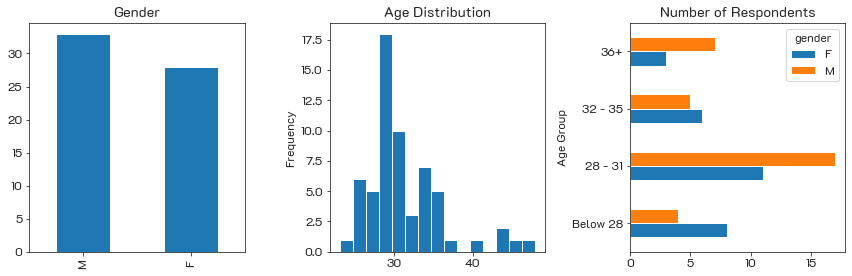

In [13]:
f, axes = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

df['gender'].value_counts(dropna=False).plot(kind='bar', title='Gender', ax=axes[0])
df['age'].plot.hist(bins=15, title='Age Distribution', ax=axes[1])
df.groupby(['age_group','gender']).size().unstack().fillna(0).plot(kind='barh', xlabel='Age Group', ylabel='Number of Respondents', 
                                                                   title='Number of Respondents', ax=axes[2]);
plt.show()

In [14]:
def process_interest(df):
    result = df.iloc[:,:30].melt(var_name='question', value_name='answer').groupby(['question','answer'], as_index=False).size().pivot('question','answer','size').fillna(0)
    result = result[intr_scale].reindex(df.columns[:30])
    result = result.apply(lambda x: x/x.sum(), axis=1)
    return result

int_overall_df = process_interest(df)
int_male_df = process_interest(df[df['gender']=='M'])
int_female_df = process_interest(df[df['gender']=='F'])

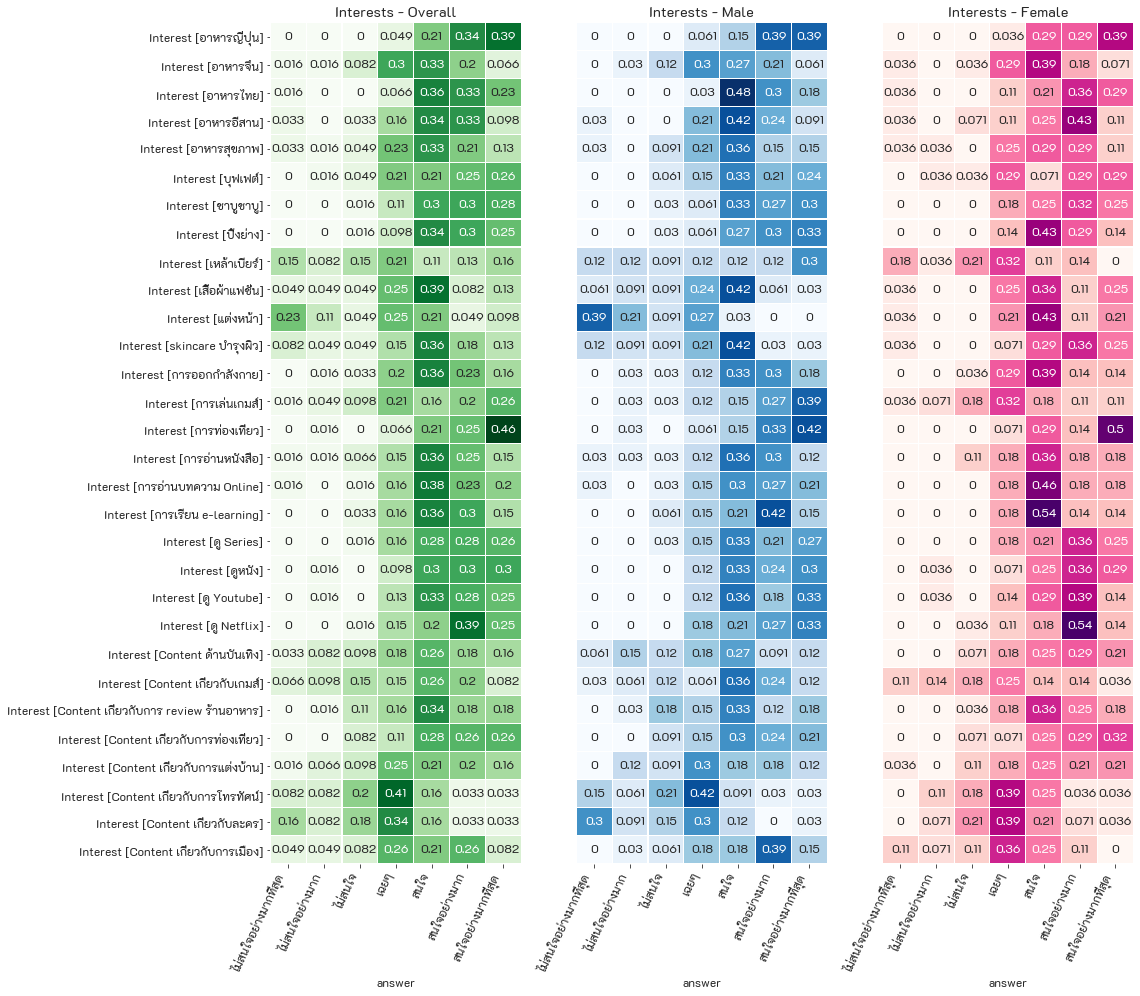

In [15]:
def plot_freq_heatmap(df, cmap, title):
    ax = sns.heatmap(df, cmap=cmap, annot=True, linewidth=.1, vmin=0, cbar=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=65, ha='right')
    ax.set_title(title)
    return ax

plt.subplots(1,3, figsize=(16,14), tight_layout=True)

plt.subplot(1,3,1)
plot_freq_heatmap(int_overall_df, 'Greens', 'Interests - Overall')

plt.subplot(1,3,2)
ax = plot_freq_heatmap(int_male_df, 'Blues', 'Interests - Male')
ax.set_yticks([])

plt.subplot(1,3,3)
ax = plot_freq_heatmap(int_female_df, 'RdPu', 'Interests - Female')
ax.set_yticks([])

plt.show()

In [16]:
def process_consumption(df):
    result = df.iloc[:,30:60].melt(var_name='question', value_name='answer').groupby(['question','answer'], as_index=False).size().pivot('question','answer','size').fillna(0)
    result = result[cons_scale].reindex(df.columns[30:60])
    result = result.apply(lambda x: x/x.sum(), axis=1)
    return result

con_overall_df = process_consumption(df)
con_male_df = process_consumption(df[df['gender']=='M'])
con_female_df = process_consumption(df[df['gender']=='F'])

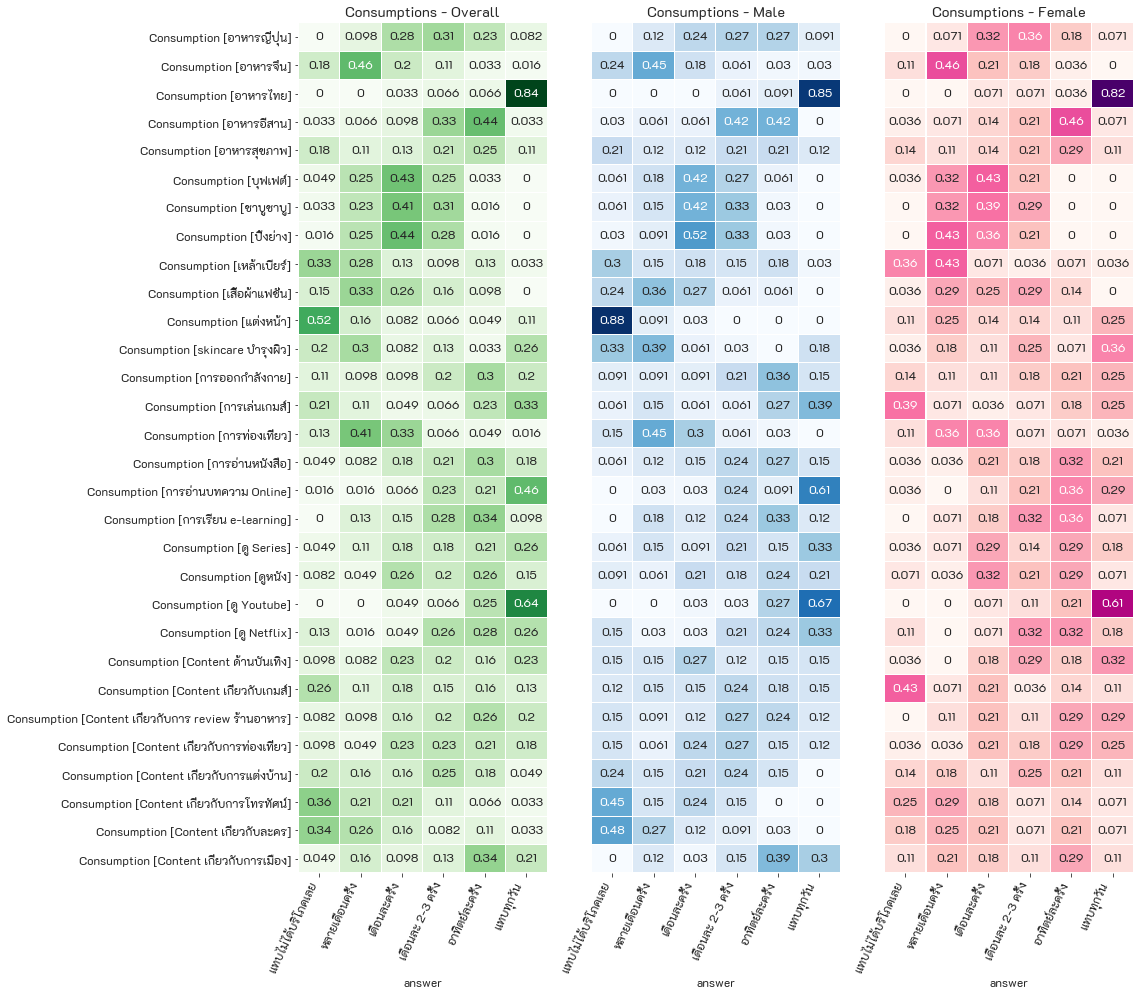

In [17]:
plt.subplots(1,3, figsize=(16,14), tight_layout=True)

plt.subplot(1,3,1)
plot_freq_heatmap(con_overall_df, 'Greens', 'Consumptions - Overall')

plt.subplot(1,3,2)
ax = plot_freq_heatmap(con_male_df, 'Blues', 'Consumptions - Male')
ax.set_yticks([])

plt.subplot(1,3,3)
ax = plot_freq_heatmap(con_female_df, 'RdPu', 'Consumptions - Female')
ax.set_yticks([])

plt.show()

In [18]:
intr_questions = list(df.columns[:30])
cons_questions = list(df.columns[30:60])

intr_mapper = { v:i for i,v in enumerate(intr_scale,1) }
cons_mapper = { v:i for i,v in enumerate(cons_scale,1) }
print(intr_mapper, cons_mapper, sep='\n')

{'ไม่สนใจอย่างมากที่สุด': 1, 'ไม่สนใจอย่างมาก': 2, 'ไม่สนใจ': 3, 'เฉยๆ': 4, 'สนใจ': 5, 'สนใจอย่างมาก': 6, 'สนใจอย่างมากที่สุด': 7}
{'แทบไม่ได้บริโภคเลย': 1, 'หลายเดือนครั้ง': 2, 'เดือนละครั้ง': 3, 'เดือนละ 2-3 ครั้ง': 4, 'อาทิตย์ละครั้ง': 5, 'แทบทุกวัน': 6}


In [19]:
score_df = df[list(df.columns[:60]) + ['gender','age_group']].copy()

for col in score_df.columns[:30]:
    score_df[col] = score_df[col].map(intr_mapper).astype(int)

for col in score_df.columns[30:60]:
    score_df[col] = score_df[col].map(cons_mapper).astype(int)

score_df = score_df.melt(id_vars=['gender','age_group'], var_name='question', value_name='score')

In [20]:
intr_score_df = score_df[score_df['question'].isin(intr_questions)]
cons_score_df = score_df[score_df['question'].isin(cons_questions)]

In [21]:
score_df = df[list(df.columns[:60]) + ['gender','age']].copy()

for col in score_df.columns[:30]:
    score_df[col] = score_df[col].map(intr_mapper).astype(int)

for col in score_df.columns[30:60]:
    score_df[col] = score_df[col].map(cons_mapper).astype(int)

In [22]:
intr_df = score_df[list(score_df.columns[:30]) + ['gender','age']]
cons_df = score_df[list(score_df.columns[30:60]) + ['gender','age']]

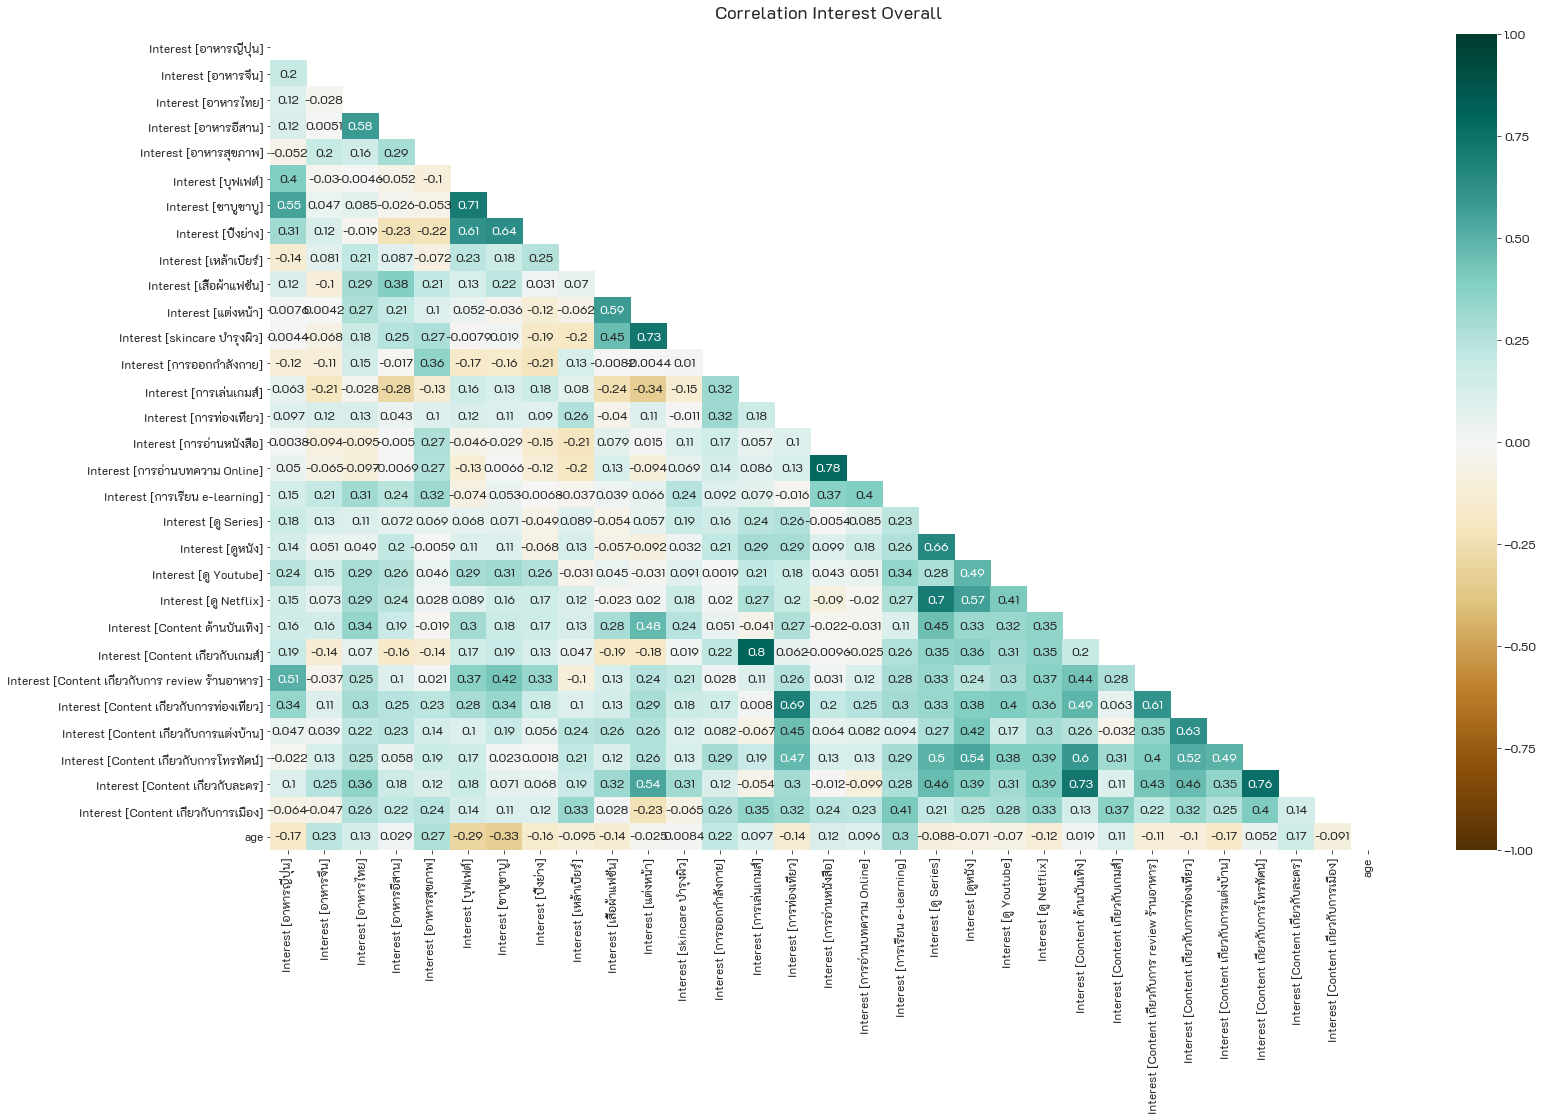

In [23]:
plt.figure(figsize=(25, 15))
mask = np.triu(np.ones_like(intr_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(intr_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Interest Overall', fontdict={'fontsize':18}, pad=16);

In [24]:
corrIntr_overall = intr_df.corr().unstack()
sorted_corrIntr_overall = corrIntr_overall.sort_values(kind="quicksort", ascending=False)

print(sorted_corrIntr_overall[(sorted_corrIntr_overall.values>0.7) & (sorted_corrIntr_overall.values<1.0)])

Interest [Content เกี่่ยวกับเกมส์]       Interest [การเล่นเกมส์]                    0.804785
Interest [การเล่นเกมส์]                  Interest [Content เกี่่ยวกับเกมส์]         0.804785
Interest [การอ่านหนังสือ]                Interest [การอ่านบทความ Online]            0.783882
Interest [การอ่านบทความ Online]          Interest [การอ่านหนังสือ]                  0.783882
Interest [Content เกี่ยวกับการโทรทัศน์]  Interest [Content เกี่ยวกับละคร]           0.763070
Interest [Content เกี่ยวกับละคร]         Interest [Content เกี่ยวกับการโทรทัศน์]    0.763070
Interest [Content ด้านบันเทิง]           Interest [Content เกี่ยวกับละคร]           0.729146
Interest [Content เกี่ยวกับละคร]         Interest [Content ด้านบันเทิง]             0.729146
Interest [skincare บำรุงผิว]             Interest [แต่งหน้า]                        0.728552
Interest [แต่งหน้า]                      Interest [skincare บำรุงผิว]               0.728552
Interest [ชาบูชาบู]                      Interest [บุฟเฟต์]           

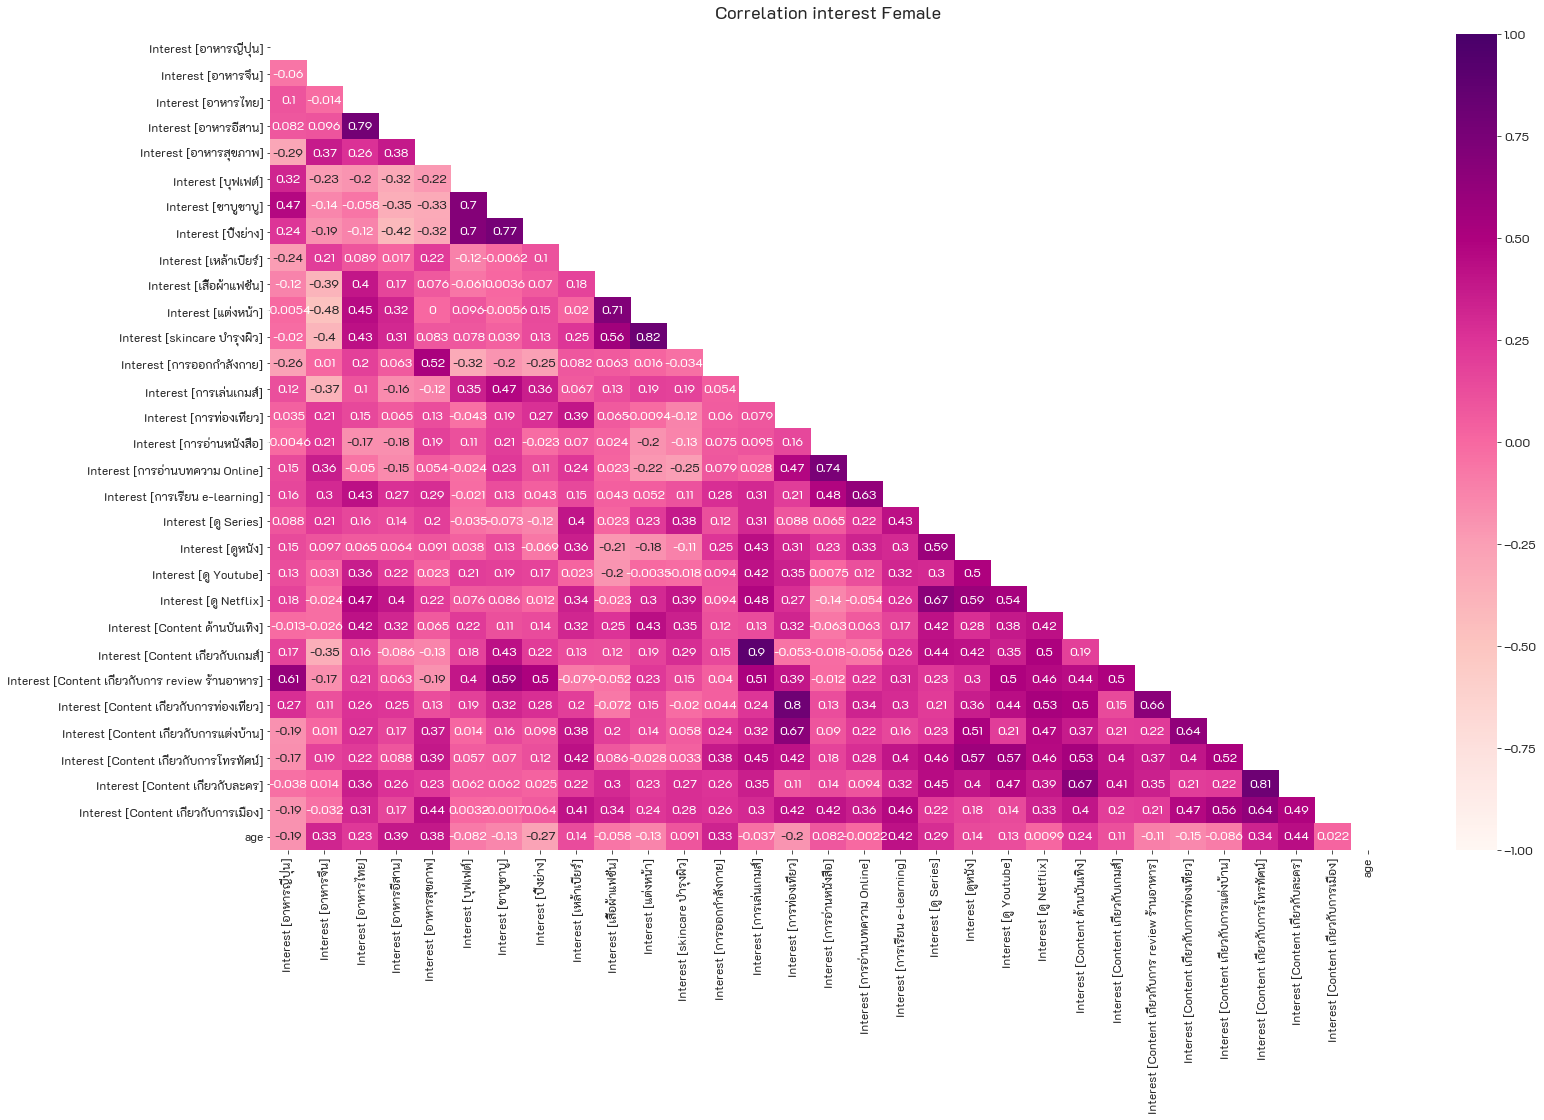

In [25]:
plt.figure(figsize=(25, 15))
mask = np.triu(np.ones_like(intr_df[intr_df['gender']=='F'].corr(), dtype=np.bool))
heatmap = sns.heatmap(intr_df[intr_df['gender']=='F'].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdPu')
heatmap.set_title('Correlation interest Female', fontdict={'fontsize':18}, pad=16);

In [26]:
corrIntr_F = intr_df[intr_df['gender']=='F'].corr().unstack()
sorted_corrIntr_F = corrIntr_F.sort_values(kind="quicksort", ascending=False)

print(sorted_corrIntr_F[(sorted_corrIntr_F.values>0.7) & (sorted_corrIntr_F.values<1.0)])

Interest [Content เกี่่ยวกับเกมส์]         Interest [การเล่นเกมส์]                      0.895406
Interest [การเล่นเกมส์]                    Interest [Content เกี่่ยวกับเกมส์]           0.895406
Interest [skincare บำรุงผิว]               Interest [แต่งหน้า]                          0.817319
Interest [แต่งหน้า]                        Interest [skincare บำรุงผิว]                 0.817319
Interest [Content เกี่ยวกับการโทรทัศน์]    Interest [Content เกี่ยวกับละคร]             0.811839
Interest [Content เกี่ยวกับละคร]           Interest [Content เกี่ยวกับการโทรทัศน์]      0.811839
Interest [Content เกี่ยวกับการท่องเที่ยว]  Interest [การท่องเที่ยว]                     0.800685
Interest [การท่องเที่ยว]                   Interest [Content เกี่ยวกับการท่องเที่ยว]    0.800685
Interest [อาหารอีสาน]                      Interest [อาหารไทย]                          0.785821
Interest [อาหารไทย]                        Interest [อาหารอีสาน]                        0.785821
Interest [ชาบูชาบู]           

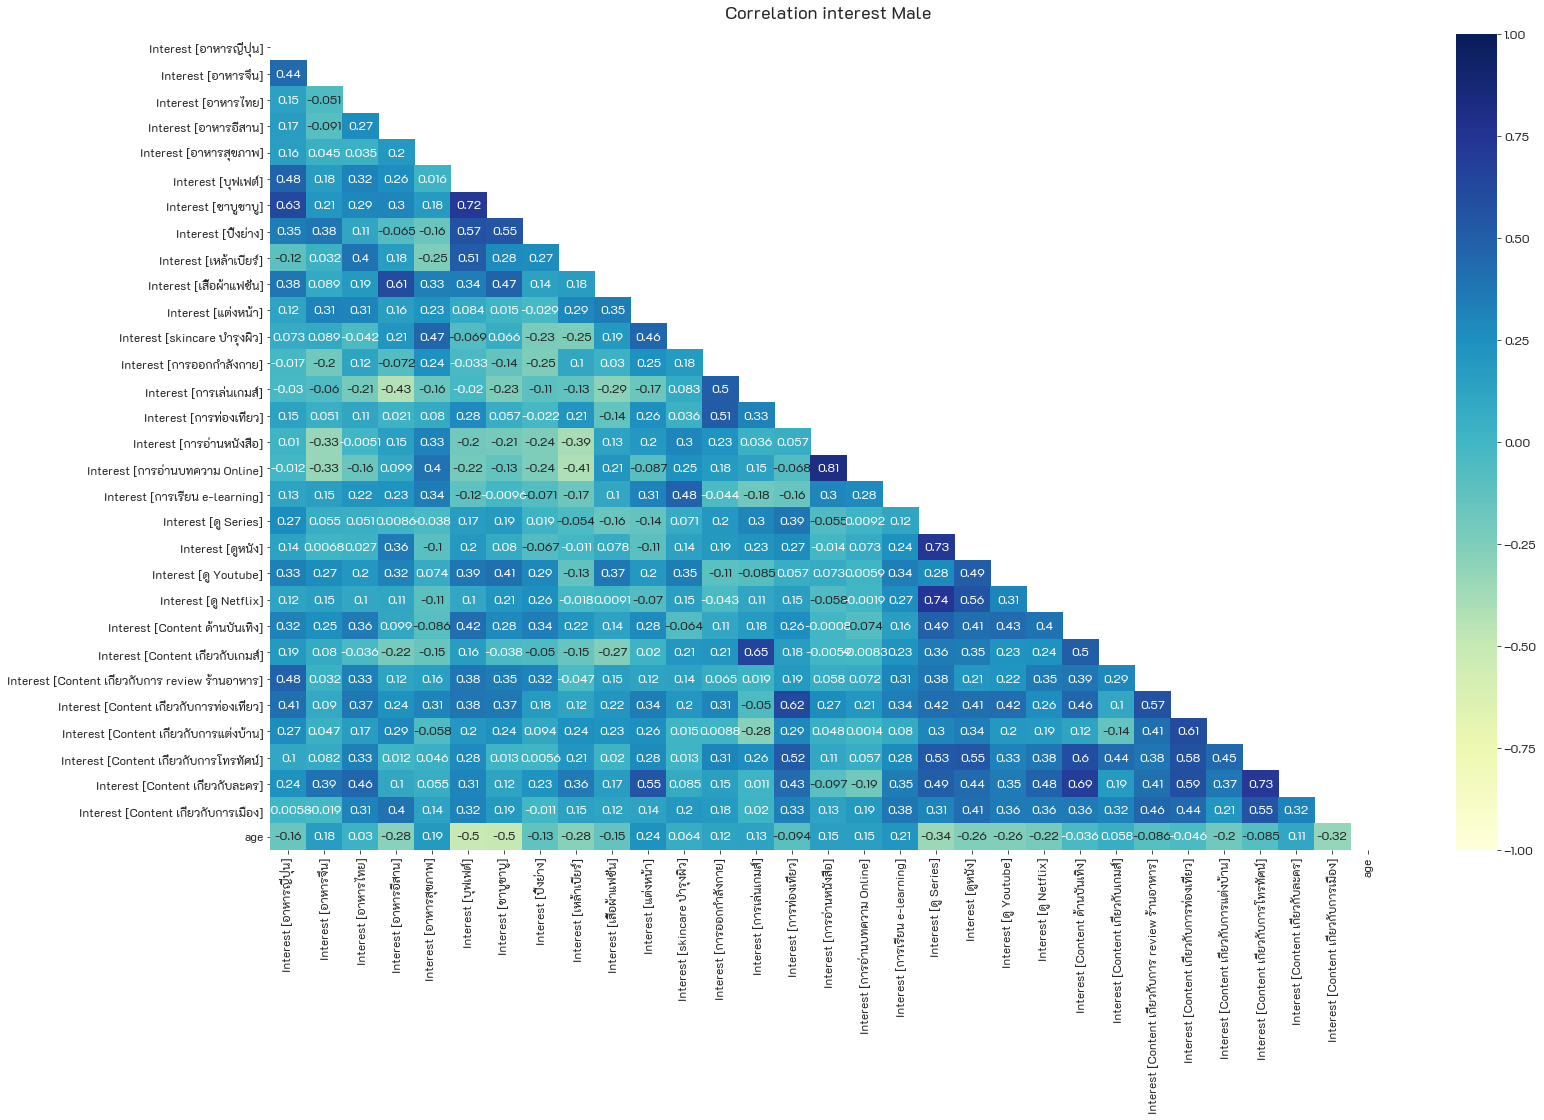

In [27]:
plt.figure(figsize=(25, 15))
mask = np.triu(np.ones_like(intr_df[intr_df['gender']=='M'].corr(), dtype=np.bool))
heatmap = sns.heatmap(intr_df[intr_df['gender']=='M'].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Correlation interest Male', fontdict={'fontsize':18}, pad=16);

In [28]:
corrIntr_M = intr_df[intr_df['gender']=='M'].corr().unstack()
sorted_corrIntr_M = corrIntr_M.sort_values(kind="quicksort", ascending=False)

print(sorted_corrIntr_M[(sorted_corrIntr_M.values>0.7) & (sorted_corrIntr_M.values<1.0)])

Interest [การอ่านหนังสือ]                Interest [การอ่านบทความ Online]            0.814342
Interest [การอ่านบทความ Online]          Interest [การอ่านหนังสือ]                  0.814342
Interest [ดู Series]                     Interest [ดู Netflix]                      0.738639
Interest [ดู Netflix]                    Interest [ดู Series]                       0.738639
Interest [ดูหนัง]                        Interest [ดู Series]                       0.731118
Interest [ดู Series]                     Interest [ดูหนัง]                          0.731118
Interest [Content เกี่ยวกับการโทรทัศน์]  Interest [Content เกี่ยวกับละคร]           0.726161
Interest [Content เกี่ยวกับละคร]         Interest [Content เกี่ยวกับการโทรทัศน์]    0.726161
Interest [ชาบูชาบู]                      Interest [บุฟเฟต์]                         0.721234
Interest [บุฟเฟต์]                       Interest [ชาบูชาบู]                        0.721234
dtype: float64


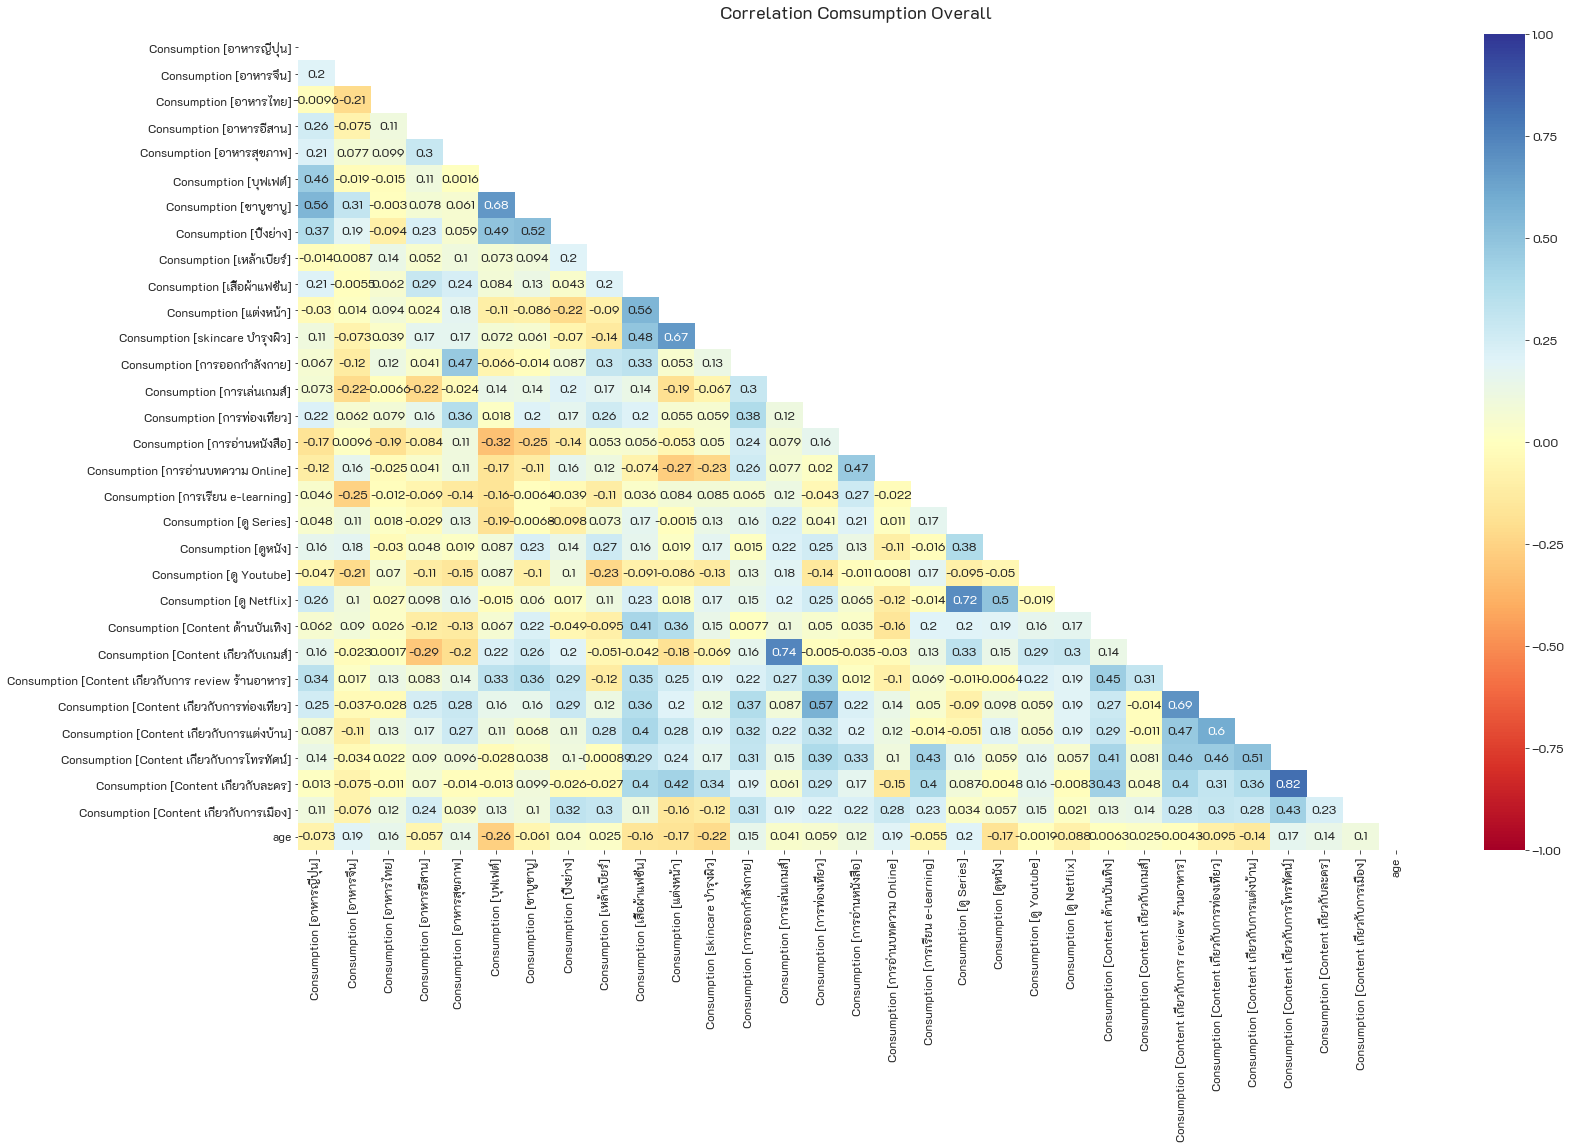

In [29]:
plt.figure(figsize=(25, 15))
mask = np.triu(np.ones_like(intr_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(cons_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlBu')
heatmap.set_title('Correlation Comsumption Overall', fontdict={'fontsize':18}, pad=16);

In [30]:
corrConsu_overall = cons_df.corr().unstack()
sorted_corrConsu_overall = corrConsu_overall.sort_values(kind="quicksort", ascending=False)

print(sorted_corrConsu_overall[(sorted_corrConsu_overall.values>0.7) & (sorted_corrConsu_overall.values<1.0)])

Consumption [Content เกี่ยวกับละคร]         Consumption [Content เกี่ยวกับการโทรทัศน์]    0.816443
Consumption [Content เกี่ยวกับการโทรทัศน์]  Consumption [Content เกี่ยวกับละคร]           0.816443
Consumption [การเล่นเกมส์]                  Consumption [Content เกี่่ยวกับเกมส์]         0.741451
Consumption [Content เกี่่ยวกับเกมส์]       Consumption [การเล่นเกมส์]                    0.741451
Consumption [ดู Series]                     Consumption [ดู Netflix]                      0.716483
Consumption [ดู Netflix]                    Consumption [ดู Series]                       0.716483
dtype: float64


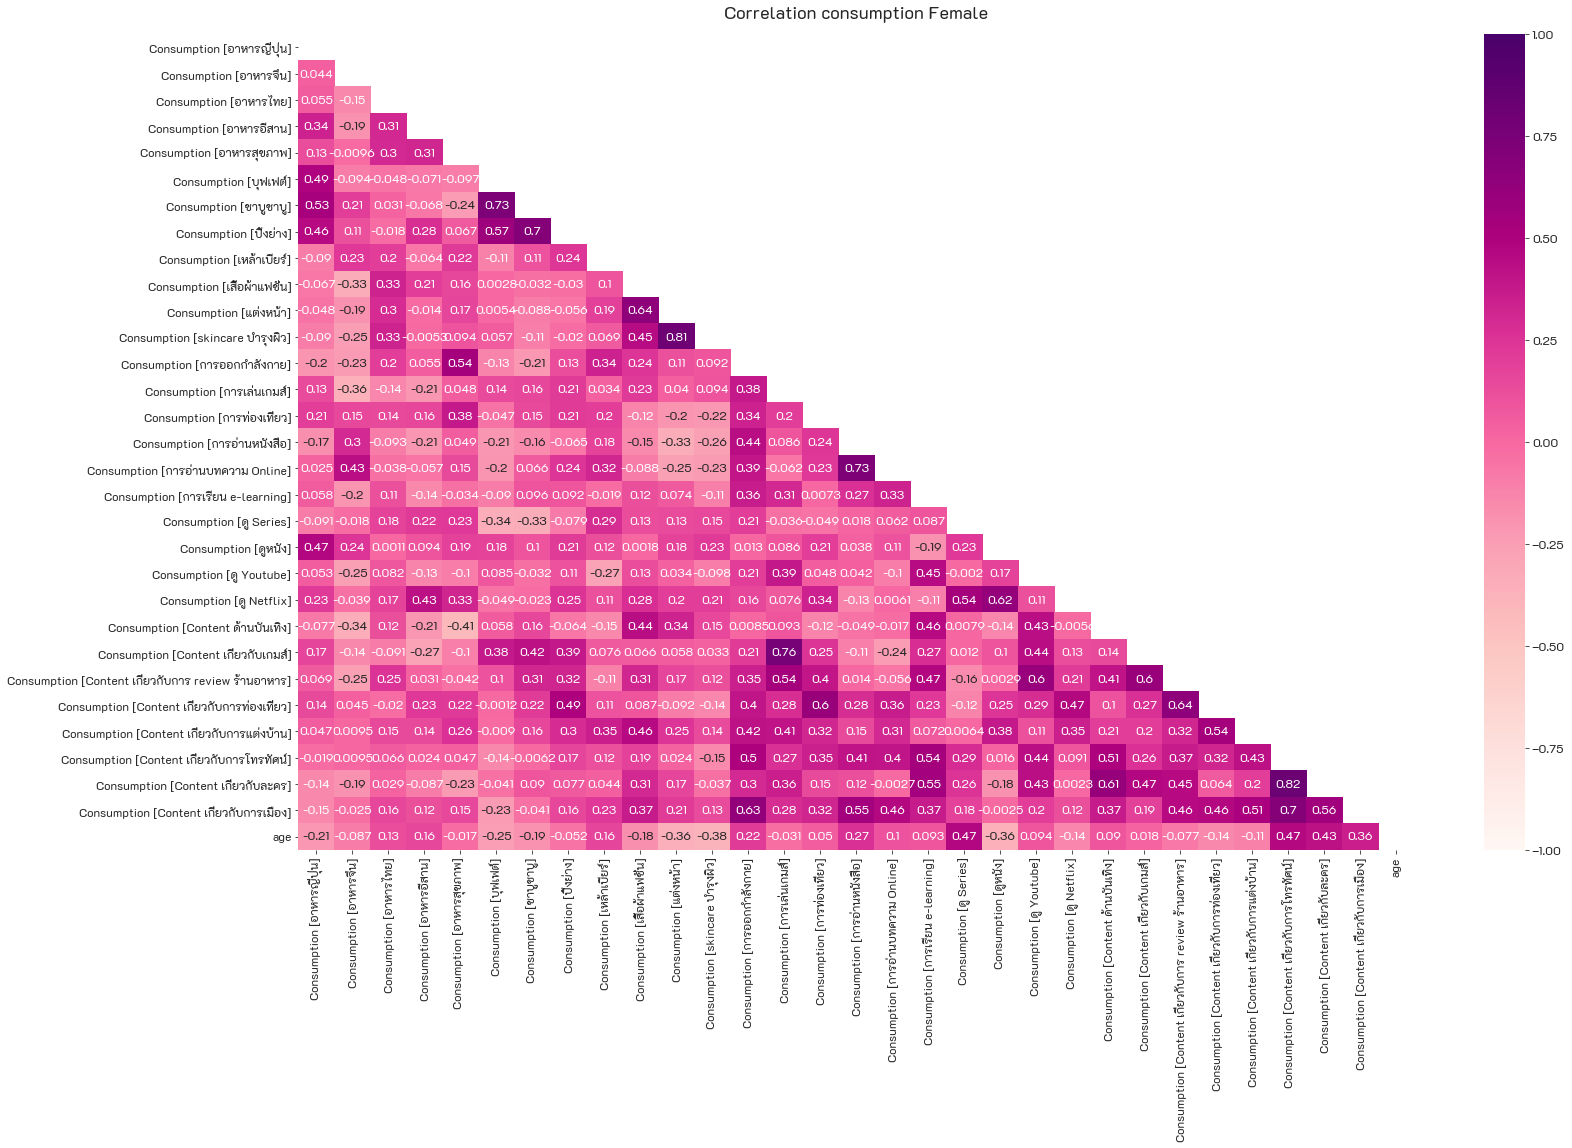

In [31]:
plt.figure(figsize=(25, 15))
mask = np.triu(np.ones_like(cons_df[cons_df['gender']=='F'].corr(), dtype=np.bool))
heatmap = sns.heatmap(cons_df[cons_df['gender']=='F'].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdPu')
heatmap.set_title('Correlation consumption Female', fontdict={'fontsize':18}, pad=16);

In [32]:
corrConsu_F = cons_df[cons_df['gender']=='F'].corr().unstack()
sorted_corrConsu_F = corrConsu_F.sort_values(kind="quicksort", ascending=False)

print(sorted_corrConsu_F[(sorted_corrConsu_F.values>0.7) & (sorted_corrConsu_F.values<1.0)])

Consumption [Content เกี่ยวกับการโทรทัศน์]  Consumption [Content เกี่ยวกับละคร]           0.815357
Consumption [Content เกี่ยวกับละคร]         Consumption [Content เกี่ยวกับการโทรทัศน์]    0.815357
Consumption [skincare บำรุงผิว]             Consumption [แต่งหน้า]                        0.809114
Consumption [แต่งหน้า]                      Consumption [skincare บำรุงผิว]               0.809114
Consumption [การเล่นเกมส์]                  Consumption [Content เกี่่ยวกับเกมส์]         0.761771
Consumption [Content เกี่่ยวกับเกมส์]       Consumption [การเล่นเกมส์]                    0.761771
Consumption [บุฟเฟต์]                       Consumption [ชาบูชาบู]                        0.731549
Consumption [ชาบูชาบู]                      Consumption [บุฟเฟต์]                         0.731549
Consumption [การอ่านหนังสือ]                Consumption [การอ่านบทความ Online]            0.726411
Consumption [การอ่านบทความ Online]          Consumption [การอ่านหนังสือ]                  0.726411
dtype: flo

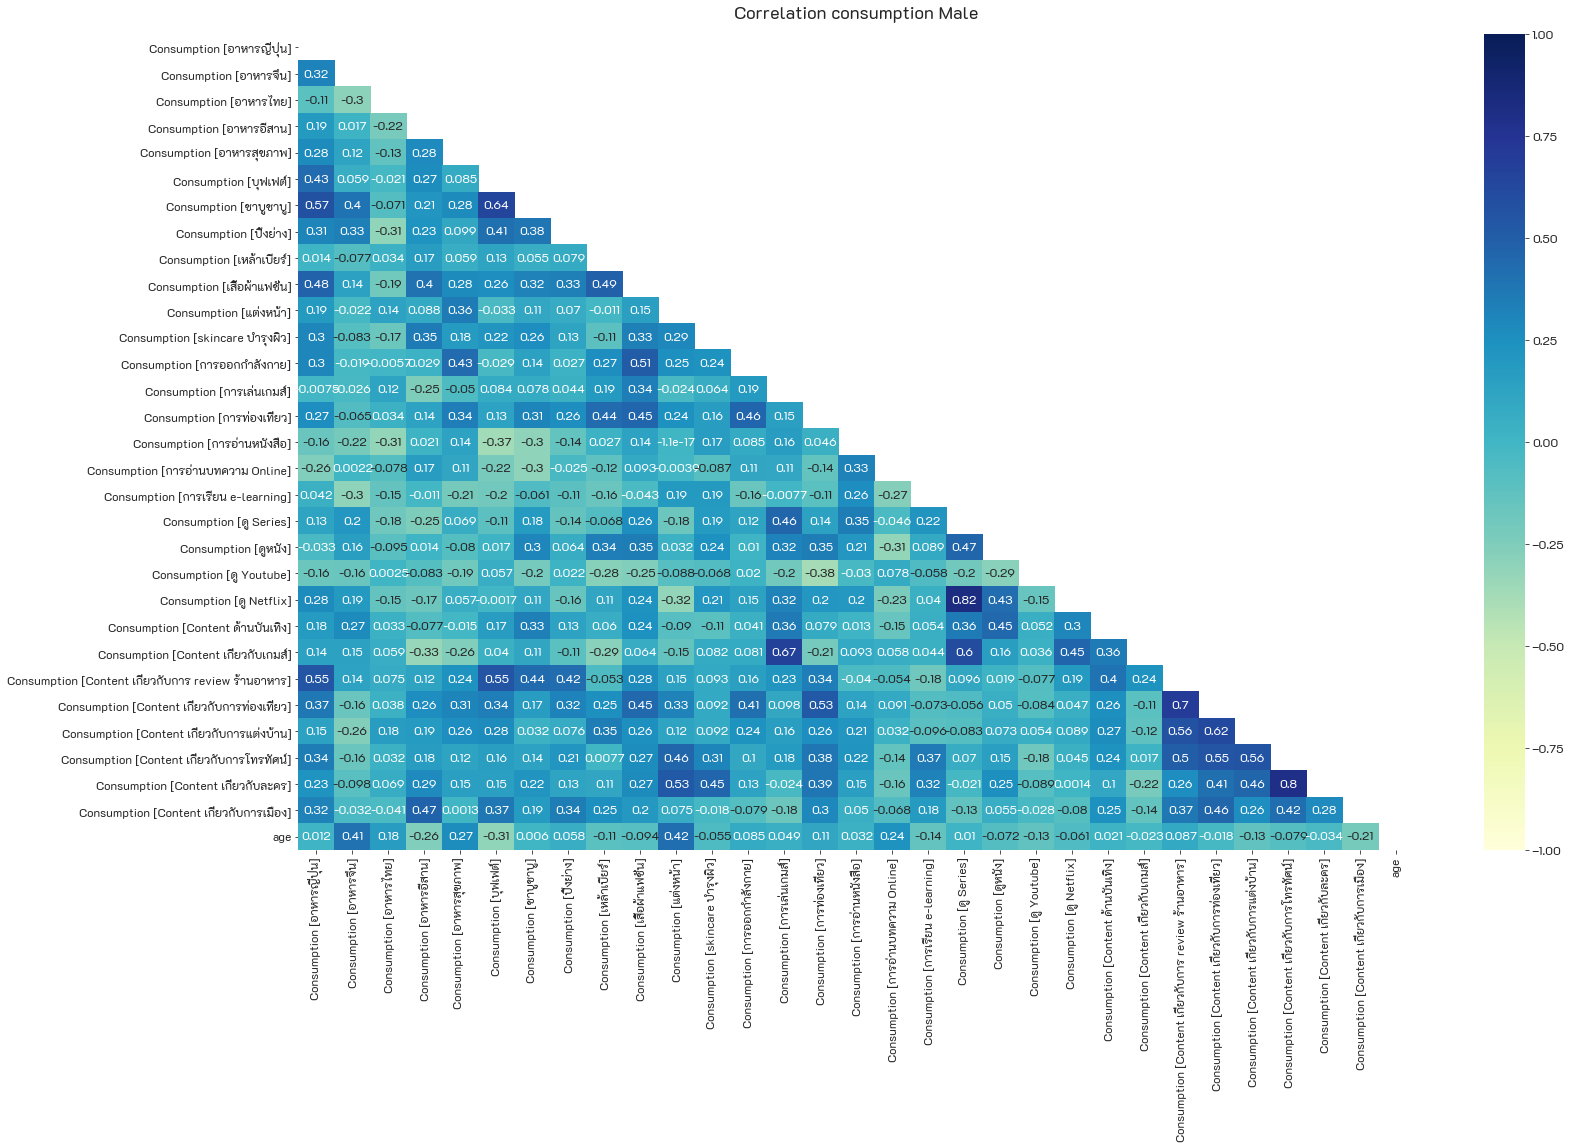

In [33]:
plt.figure(figsize=(25, 15))
mask = np.triu(np.ones_like(cons_df[cons_df['gender']=='M'].corr(), dtype=np.bool))
heatmap = sns.heatmap(cons_df[cons_df['gender']=='M'].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='YlGnBu')
heatmap.set_title('Correlation consumption Male', fontdict={'fontsize':18}, pad=16);

In [34]:
corrConsu_M = cons_df[cons_df['gender']=='M'].corr().unstack()
sorted_corrConsu_M = corrConsu_M.sort_values(kind="quicksort", ascending=False)

print(sorted_corrConsu_M[(sorted_corrConsu_M.values>0.7) & (sorted_corrConsu_M.values<1.0)])

Consumption [ดู Netflix]                    Consumption [ดู Series]                       0.820609
Consumption [ดู Series]                     Consumption [ดู Netflix]                      0.820609
Consumption [Content เกี่ยวกับการโทรทัศน์]  Consumption [Content เกี่ยวกับละคร]           0.797615
Consumption [Content เกี่ยวกับละคร]         Consumption [Content เกี่ยวกับการโทรทัศน์]    0.797615
dtype: float64
